# Scvelo analysis

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scvelo as scv
import cellrank as cr
import matplotlib.pyplot as plt

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
Path='/home/mgander/pancreas_multiome/data2'
adata=sc.read_h5ad(f'{Path}/Lung_adata.h5ad')

In [3]:
adata.obs['day'].value_counts()

21.0    5510
70.0    3065
42.0    2833
0.0     1758
28.0    1625
Name: day, dtype: int64

/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


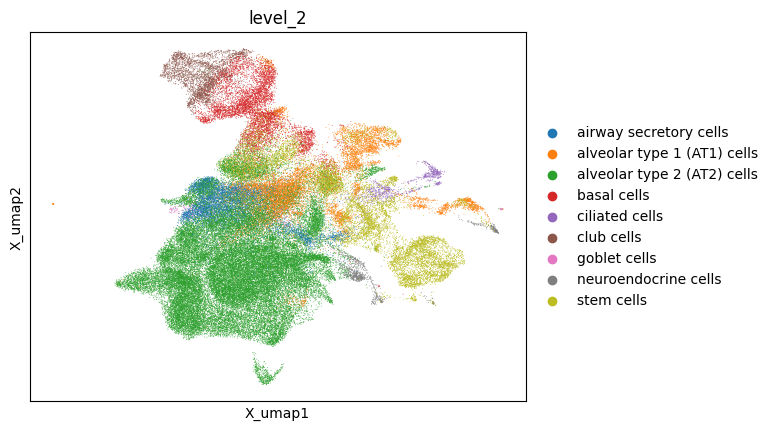

In [4]:
sc.pl.embedding(adata, basis='X_umap', color='level_2')

# Calculating RNA velocities

In [5]:
scv.pp.moments(adata, use_rep='X_scPoli')

Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:02:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:53) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [6]:
scv.tl.recover_dynamics(adata, n_jobs=5)

recovering dynamics (using 5/32 cores)


  0%|          | 0/1330 [00:00<?, ?gene/s]

    finished (0:56:49) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


In [7]:
scv.tl.velocity(adata, mode="dynamical")

computing velocities
    finished (0:05:11) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [8]:
adata.write(f'{Path}/Lung_scvelo_adata.h5ad')

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scvelo as scv
import cellrank as cr
import matplotlib.pyplot as plt

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
Path='/home/mgander/pancreas_multiome/data2'
adata=sc.read_h5ad(f'{Path}/Lung_scvelo_adata.h5ad')

In [3]:
scv.tl.velocity_graph(adata, n_jobs=10)

computing velocity graph (using 10/32 cores)


  0%|          | 0/88729 [00:00<?, ?cells/s]

/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:03:16) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


# Cellrank to determine terminal states

In [4]:
vk=cr.kernels.VelocityKernel(adata)

In [5]:
vk.compute_transition_matrix()

  0%|          | 0/88729 [00:00<?, ?cell/s]

  0%|          | 0/88729 [00:00<?, ?cell/s]

VelocityKernel[n=88729, model='deterministic', similarity='correlation', softmax_scale=5.65]

/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


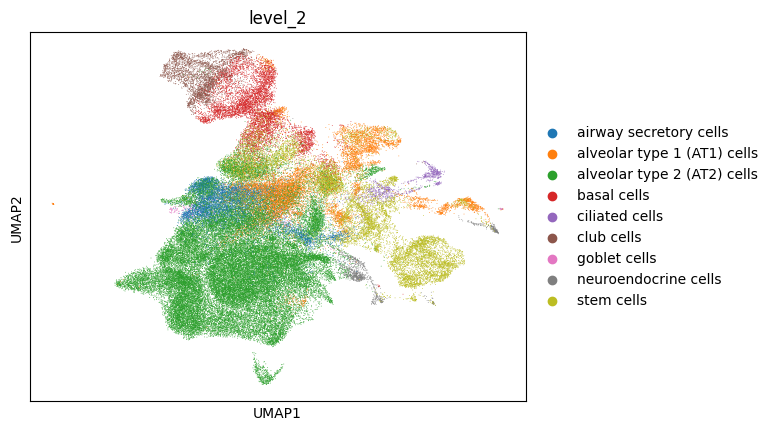

In [6]:
sc.pl.umap(adata, color='level_2')

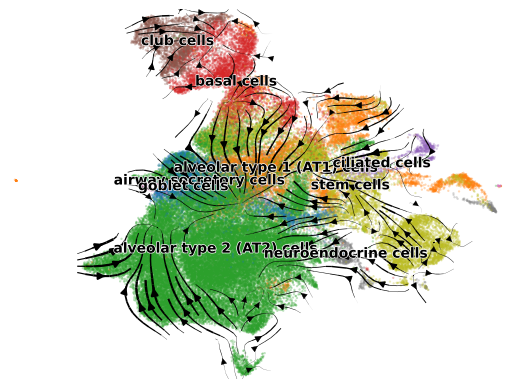

In [9]:
# This is the stream plot for only moscot+dpt (both weighted *0.5)
vk.plot_projection(basis='X_umap', color="level_2", recompute=True, 
                   connectivities=adata.obsp['connectivities'], title='')

In [10]:
import pickle
tm=vk.transition_matrix
with open(f'{Path}/scvelo_lung.pkl', 'wb') as handle:
    pickle.dump(tm, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
tm

<88729x88729 sparse matrix of type '<class 'numpy.float64'>'
	with 4062800 stored elements in Compressed Sparse Row format>